<a href="https://colab.research.google.com/github/cuillerj/ApeRobot/blob/master/ColorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Classify objects by color tutorial

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

This is based on FruitToEmoji-GIT.ipynb
The aim is to classify colors with deep learning with an NANO 33 BLE sense
I added the clear data to the 3 red blue green in the capture file
I added one layer to the learning model

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

requires tensorflow version 2

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/v/vim/xxd_8.0.1453-1ubuntu1.1_amd64.deb  404  Not Found [IP: 91.189.88.152 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the Files tab
1. Drag `csv` files from your computer to the tab to upload them into colab /content

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.



TensorFlow version = 2.2.0-rc1

Nb classes= 4

blue class will be output 0 of the classifier
241 samples captured for training with inputs ['Red', 'Green', 'Blue', 'Lux'] 



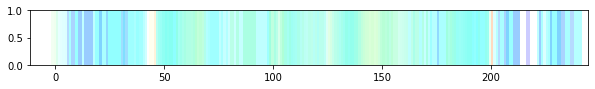

green class will be output 1 of the classifier
228 samples captured for training with inputs ['Red', 'Green', 'Blue', 'Lux'] 



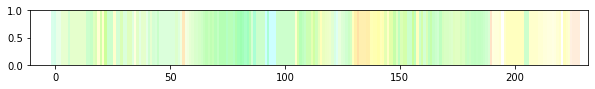

red class will be output 2 of the classifier
286 samples captured for training with inputs ['Red', 'Green', 'Blue', 'Lux'] 



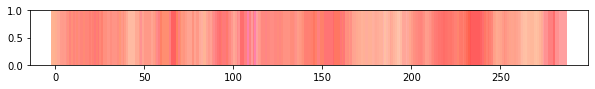

yellow class will be output 3 of the classifier
286 samples captured for training with inputs ['Red', 'Green', 'Blue', 'Lux'] 



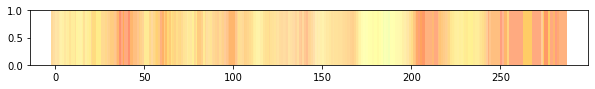

Data set parsing and preparation complete.
Data set randomization and splitting complete.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
import os
import fileinput

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("/content/"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()

SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)
print(f"Nb classes= {NUM_CLASSES}\n")

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("/content/" + objectClass + ".csv")
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
   
  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")

  # graphing
  plt.rcParams["figure.figsize"] = (10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=400, batch_size=4, validation_data=(inputs_validate, outputs_validate))



Epoch 1/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1862 - mae: 0.3736 - val_loss: 0.1835 - val_mae: 0.3708
Epoch 2/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1785 - mae: 0.3651 - val_loss: 0.1709 - val_mae: 0.3563
Epoch 3/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1627 - mae: 0.3450 - val_loss: 0.1539 - val_mae: 0.3336
Epoch 4/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1457 - mae: 0.3198 - val_loss: 0.1384 - val_mae: 0.3087
Epoch 5/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1308 - mae: 0.2931 - val_loss: 0.1308 - val_mae: 0.2916
Epoch 6/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1205 - mae: 0.2725 - val_loss: 0.1199 - val_mae: 0.2714
Epoch 7/400
156/156 [==============================] - 0s 2ms/step - loss: 0.1133 - mae: 0.2591 - val_loss: 0.1131 - val_mae: 0.2583
Epoch 8/400
156/156 [==============================] - 0s 2ms/step - 

### Run with Test Data
Put our test data into the model and plot the predictions


predictions =
 [[0.    0.999 0.    0.001]
 [0.    0.    0.    1.   ]
 [0.013 0.987 0.    0.   ]
 [0.998 0.002 0.    0.   ]
 [0.    0.065 0.    0.935]
 [0.002 0.998 0.    0.   ]
 [0.    0.    0.    0.999]
 [0.998 0.002 0.    0.   ]
 [0.001 0.999 0.    0.   ]
 [0.982 0.018 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.995 0.005 0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.012 0.988]
 [0.007 0.993 0.    0.   ]
 [0.    0.008 0.    0.992]
 [0.998 0.002 0.    0.   ]
 [0.005 0.992 0.    0.003]
 [0.    0.    1.    0.   ]
 [0.998 0.002 0.    0.   ]
 [0.987 0.013 0.    0.   ]
 [0.262 0.738 0.    0.   ]
 [0.    0.135 0.001 0.864]
 [0.049 0.947 0.    0.004]
 [0.    0.    0.    1.   ]
 [0.    0.    0.001 0.999]
 [0.996 0.004 0.    0.   ]
 [0.    0.302 0.    0.698]
 [0.    0.005 0.    0.994]
 [0.    0.    0.898 0.102]
 [0.    0.    0.    1.   ]
 [0.997 0.003 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.999]
 [0.    0.   

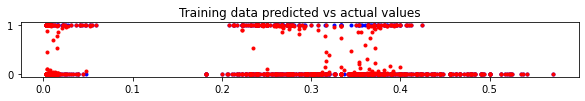

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 3184 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

/bin/bash: xxd: command not found
Header file, model.h, is 35 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Realtime Classification of Sensor Data on Arduino

Now it's time to switch back to the tutorial instructions and run our new model on the [Arduino Nano 33 BLE Sense](https://www.arduino.cc/en/Guide/NANO33BLE)

# Nouvelle section